In [88]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch.nn as nn

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [87]:
# Read the h-indices
df = pd.read_csv('../Data/train.csv', dtype={'author': np.int64, 'hindex': np.float32})

# Load the graph    
G = nx.read_edgelist('../Data/coauthorship.edgelist', delimiter=' ', nodetype=int)
core_num = nx.core_number(G)

Let's take a quick look at the data

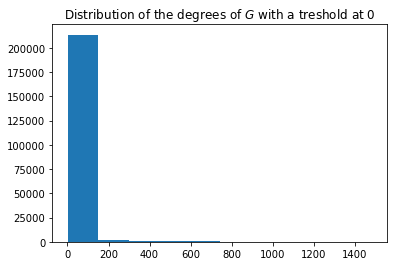

In [85]:
treshold = 0

# Degree distribution
l = []
for node in G:
    if G.degree(node) > treshold:
        l.append(G.degree(node))

plt.hist(l)
plt.title("Distribution of the degrees of $G$ with a treshold at {}".format(treshold))
print()

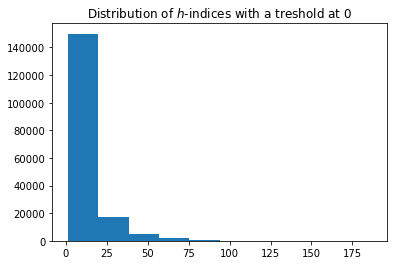

In [86]:
treshold = 0

# Distribution of h-indices
hindex = df['hindex']
plt.hist(hindex[hindex > treshold])
plt.title("Distribution of $h$-indices with a treshold at {}".format(treshold))
print()

# Learning

Here we attempt to predict the $h$-indices based only on properties of the graph

We split the dataframe into a dataframe for training and a dataframe for testing

In [121]:
# Fraction of samples in the training set
train_frac = 0.7
# Split the dataframe into train and test dataframes
df_train = df.sample(frac = train_frac)
df_test = df.drop(df_train.index)

### Baseline

We try to reproduce the score of the baseline using only the training dataset (because we do not have the answers for the testing dataset).

In [122]:
# Builds the feature vectors and target vector from the dataframe
# Here we reproduce the features of the baseline
def featvecs_baseline(df):
    n = df.shape[0]
    X = np.zeros((n,2))
    y = np.zeros(n)
    for i, x in zip(range(n), df.iterrows()):
        _, row = x
        X[i,0] = G.degree(row['author'])
        X[i,1] = core_num[row['author']]
        y[i] = row['hindex']
    return X,y

In [123]:
# Fitting a lasso model like in the baseline

X_train, y_train = featvecs_baseline(df_train)
print("Training features built")

X_test, y_test = featvecs_baseline(df_test)
print("Testing features built\n")

reg = Lasso(alpha = 0.1)
reg.fit(X_train, y_train)
print("Model fitted\n")

y_pred = reg.predict(X_test)
print("MSE: {:.4}".format(mean_squared_error(y_pred, y_test)))

Training features built
Testing features built

Model fitted

MSE: 129.7


### Experimental Area

Here is for experimenting with different kinds of graph-based features.

Let's try to add different powers of the degrees. In particular, we expect a dependance with the square root of the degree.

In [148]:
# Builds the feature vectors and target vector from the dataframe

def featvecs_experimental(df, powers):
    n = df.shape[0]
    X = np.zeros((n,len(powers)))
    y = np.zeros(n)
    for i, x in zip(range(n), df.iterrows()):
        _, row = x
        deg = G.degree(row['author'])
        cn = core_num[row['author']]
        for j, power in enumerate(powers):
            X[i,j] = deg ** power
            #X[i,j + len(powers)] = cn ** power
        y[i] = row['hindex']
    return X,y

In [163]:
# Fitting a lasso model like in the baseline

lp = np.linspace(0.1, 1, 5)
lmse = []

for i,p in enumerate(lp):
    powers = [p]

    X_train, y_train = featvecs_experimental(df_train, powers)
    #print("Training features built")

    X_test, y_test = featvecs_experimental(df_test, powers)
    #print("Testing features built")

    reg = Lasso(alpha = 0.1, max_iter = 1e5)
    reg.fit(X_train, y_train)
    #print("Model fitted\n")

    y_pred = reg.predict(X_test)
    lmse.append(mean_squared_error(y_pred, y_test))
    #print("MSE: {:.4}".format(mean_squared_error(y_pred, y_test)))
    
    print("{:.2%}".format((i+1)/len(lp)))

20.00%
40.00%
60.00%
80.00%
100.00%


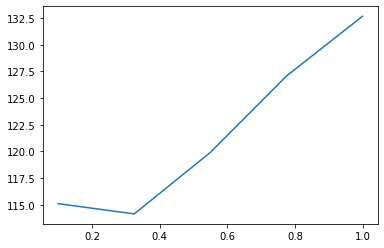

In [164]:
plt.plot(lp, lmse)

### Fitting the basic graph features with a neural network

In [ ]:
model = nn.Sequential(nn.Linear(len(powers), 10), nn.ReLU(), nn.Linear(10, 1))